## TUTORIAL 12 - Stokes Equations
**_Keywords: geometrical parametrization, POD-Galerkin method, mixed formulation, inf sup condition_**

### 1. Introduction

This tutorial addresses geometrical parametrization and the POD-Galerkin method applied to the steady Stokes equations in a domain $\Omega_o \subset \mathbb{R}^2$ divided into 4 parts with boundary $\Gamma_o$ shown below:

<img src="data/t_bypass.png" width="50%"/>

The problem is characterized by six parameters. We introduce a vector of parameters $\boldsymbol{\mu} = \{t,D,L,S,H,\theta \}$ that control the shape of the subdomains. The ranges of the six parameters are the following:

The parameter vector $\boldsymbol{\mu}$ is thus given by $$\boldsymbol{\mu}=(\mu_0,\mu_1,\mu_2,\mu_3,\mu_4,\mu_5)$$ which corresponds to $\boldsymbol{\mu} = \{t,D,L,S,H,\theta \}$, respectively, on the parameter domain $$\mathbb{P}=[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0.5,1.5]\times[0,\pi/6]$$

In this program, we apply the following conditions on the boundaries: 
* Zero velocity on the left boundary $\Gamma_{o,w}$ 
* Constant inflow on the right boundary $\Gamma_{o,in}$
* Stress free Neumann condition on the bottom boundary $\Gamma_{o,out}$

In order to obtain a faster approximation of the problem we pursue a model reduction by means of a POD-Galerkin reduced order method from a fixed reference domain.



### 2. Parametrized formulation

Let $\boldsymbol{u_o}(\boldsymbol{\mu})$ be the velocity vector and $p_o(\boldsymbol{\mu})$ be the pressure in the domain $\Omega_o(\boldsymbol{\mu})$.

We will directly provide a weak formulation for this problem:
for a given parameter $\boldsymbol{\mu} \in\mathbb{P}$, find $\boldsymbol{u_o}(\boldsymbol{\mu}) \in\mathbb{V_o}(\boldsymbol{\mu})$, $p_o \in\mathbb{M_o}$ such that 

<center>
    $
    \begin{cases}
        \nu \int_{\Omega_o} \nabla \boldsymbol{u_o} : \nabla \boldsymbol{v_o} \ d\Omega - \int_{\Omega_o} p_o \nabla \cdot \boldsymbol{v_o} \ d\Omega = \int_{\Omega_o} \boldsymbol{f_o} \cdot \boldsymbol{v_o} \ d\Omega, \quad \forall \boldsymbol{v_o} \in\mathbb{V_o},  \\
        \int_{\Omega_o} q_o \nabla \cdot \boldsymbol{u_o} \ d\Omega = 0, \quad \forall q_o \in\mathbb{M_o}
    \end{cases}
    $
</center>

where

* $\nu$ represents kinematic viscosity
* the functional space $\mathbb{V_o}(\boldsymbol{\mu})$ is defined as $$\mathbb{V_o}(\boldsymbol{\mu}) = [H_{\Gamma_{o,w}}^{1}(\Omega_o)]^2$$
* the functional space $\mathbb{M_o}(\boldsymbol{\mu})$ is defined as $$\mathbb{M_o}(\boldsymbol{\mu}) = L^2(\Omega_o)$$ Note that the functional spaces are parameter dependent due to the shape variation

Since this problem utilizes mixed finite element discretization with the velocity and pressure as solution variables, the inf-sup condition is necessary for the well posedness of this problem. Thus, the supremizer operator $T^{\mu}: \mathbb{M_o}_h \rightarrow \mathbb{V_o}_h$ will be used.


In [1]:
from dolfin import *
from rbnics import *
from sampling import LinearlyDependentUniformDistribution

import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

In order to obtain an affine decomposition, we recast the problem on a fixed, parameter independent, reference domain $\Omega$. We choose one characterized by $\mu_0=\mu_1=\mu_2=\mu_3=\mu_4=1$ and $\mu_5=0$, which we generate through the generate_mesh notebook provided in the *data* folder. 



In [2]:
@PullBackFormsToReferenceDomain()
@AffineShapeParametrization("data/t_bypass_vertices_mapping.vmp")
class Stokes(StokesProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        StokesProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        up = TrialFunction(V)
        (self.u, self.p) = split(up)
        vq = TestFunction(V)
        (self.v, self.q) = split(vq)
        self.dx = Measure("dx")(subdomain_data=self.subdomains)
        self.ds = Measure("ds")(subdomain_data=self.boundaries)
        #
        self.f = Constant((0.0, -10.0))
        self.g = Constant(0.0)

    # Return custom problem name
    def name(self):
        return "Stokes1POD"

    # Return theta multiplicative terms of the affine expansion of the problem.
    @compute_theta_for_supremizers
    def compute_theta(self, term):
        if term == "a":
            theta_a0 = 1.0
            return (theta_a0, )
        elif term in ("b", "bt"):
            theta_b0 = 1.0
            return (theta_b0, )
        elif term == "f":
            theta_f0 = 1.0
            return (theta_f0, )
        elif term == "g":
            theta_g0 = 1.0
            return (theta_g0, )
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    @assemble_operator_for_supremizers
    def assemble_operator(self, term):
        dx = self.dx
        if term == "a":
            u = self.u
            v = self.v
            a0 = inner(grad(u), grad(v)) * dx
            return (a0, )
        elif term == "b":
            u = self.u
            q = self.q
            b0 = - q * div(u) * dx
            return (b0, )
        elif term == "bt":
            p = self.p
            v = self.v
            bt0 = - p * div(v) * dx
            return (bt0, )
        elif term == "f":
            v = self.v
            f0 = inner(self.f, v) * dx
            return (f0, )
        elif term == "g":
            q = self.q
            g0 = self.g * q * dx
            return (g0, )
        elif term == "dirichlet_bc_u":
            bc0 = [DirichletBC(self.V.sub(0), Constant((0.0, 0.0)), self.boundaries, 3)]
            return (bc0, )
        elif term == "inner_product_u":
            u = self.u
            v = self.v
            x0 = inner(grad(u), grad(v)) * dx
            return (x0, )
        elif term == "inner_product_p":
            p = self.p
            q = self.q
            x0 = inner(p, q) * dx
            return (x0, )
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/t_bypass.xml")
subdomains = MeshFunction("size_t", mesh, "data/t_bypass_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/t_bypass_facet_region.xml")

### 4.2. Create Finite Element space (Taylor-Hood P2-P1)

In [4]:
element_u = VectorElement("Lagrange", mesh.ufl_cell(), 2)
element_p = FiniteElement("Lagrange", mesh.ufl_cell(), 1)
element = MixedElement(element_u, element_p)
V = FunctionSpace(mesh, element, components=[["u", "s"], "p"])

### 4.3. Allocate an object of the Stokes class

In [5]:
problem = Stokes(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0.5, 1.5),
    (0., pi / 6.)
]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a POD-Galerkin method

In [6]:
reduction_method = PODGalerkin(problem)
reduction_method.set_Nmax(25)
reduction_method.set_tolerance(1e-6)

### 4.5. Perform the offline phase

In [7]:
reduction_method.initialize_training_set(10, sampling=LinearlyDependentUniformDistribution())
reduced_problem = reduction_method.offline()

In [8]:
net = NN.RONN(problem, reduction_method)

reduction_method.initialize_testing_set(10)
test_mu, val_mu = NN.get_test_validation(net, validation_proportion=0.2)

In [9]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [10]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [13]:
NN.normalize_and_train(net, pinn_loss, input_normalization, 
                       lr=0.001, epochs=10000, validation_set=None)

0 0.4051827585963551
100 0.2667107734793351
200 0.17952973086377547
300 0.12996146899854502
400 0.0949724944519169
500 0.06798304889138904
600 0.04881241346352569
700 0.03626873863631652
800 0.02555769973963542
900 0.019135333234444527
1000 0.01515773981111265
1100 0.012352563191192028
1200 0.010337225611639264
1300 0.009390564170944849
1400 0.00770543510251153
1500 0.0068466547552598666
1600 0.0061708772367765384
1700 0.005496863987671491
1800 0.004971890350234114
1900 0.0045048765814875436
2000 0.0045045055529862035
2100 0.004057834966951863
2200 0.0036612206453879477
2300 0.011993056210375214
2400 0.003127955021090748
2500 0.0029392338615943977
2600 0.0028588106899216066
2700 0.0025967425024413355
2800 0.002404986545332513
2900 0.0023608448738858066
3000 0.002220206468337204
3100 0.009058760611719226
3200 0.015517911098778377
3300 0.002400242000359577
3400 0.007964790670265072
3500 0.0019468062165643122
3600 0.001667812212964292
3700 0.0016232524361043936
3800 0.0016907478890305868


### 4.6. Perform an online solve

In [20]:
online_mu = (1.0, 1.0, 1.0, 1.0, 1.0, pi / 6.)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
print(reduced_solution)

[-2.97723307e+00 -1.73819003e-01  5.27737096e-01  8.08572131e-02
  7.29858893e-02 -1.88452396e-01 -8.63193570e-03 -3.95754073e-02
 -8.27587017e-02 -2.11561447e-04 -1.47135969e-02 -3.13052826e-02
 -1.82649861e-02 -2.65170519e-02 -3.39918544e-03 -1.44730999e-02
 -1.42789287e-03 -2.43733596e-02 -3.26220096e-03  4.16975897e-03
 -1.90908004e+01 -1.68026714e+00 -5.49866429e-01 -3.47225652e-01
 -2.54197533e-01  1.05111156e-01 -7.78783565e-02  3.00719113e-02]


In [21]:
net.eval()

with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    # NOTE: Change output_normalization accordingly for the different losses
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization=None)
    print(reduced_solution_nn)
net.train()

[-1.57234609e+00  2.48595521e-01  5.47154427e-01  1.56634539e-01
 -7.96654880e-01 -2.31765866e-01 -2.08132058e-01 -1.93489566e-01
 -2.50324637e-01 -1.04816310e-01 -3.37909609e-02 -1.92666829e-01
  1.76680148e-01 -1.51778722e+00  3.25706482e-01 -4.11917567e-01
 -4.49205339e-01 -6.38500154e-02 -1.46165453e-02  6.60463572e-02
 -1.89159908e+01 -1.80169630e+00 -5.89998364e-01 -4.72957611e-01
  3.24774772e-01 -1.17775691e+00 -2.23173112e-01  1.14376724e-01]


RONN(
  (layers): ModuleList(
    (0): Linear(in_features=6, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): Linear(in_features=100, out_features=28, bias=True)
  )
)

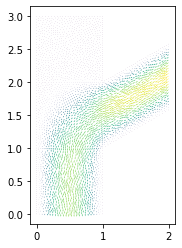

In [22]:
plot(reduced_solution, reduced_problem=reduced_problem, component="u")

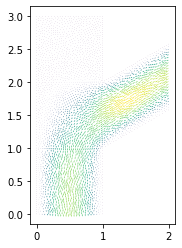

In [23]:
plot(reduced_solution_nn, reduced_problem=reduced_problem, component="u")

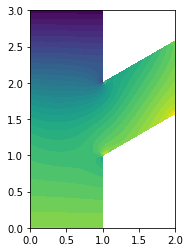

In [24]:
plot(reduced_solution, reduced_problem=reduced_problem, component="p")

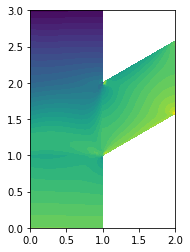

In [25]:
plot(reduced_solution_nn, reduced_problem=reduced_problem, component="p")

In [ ]:
problem.operator['a'][0].array().shape

In [ ]:
V.dim()

In [ ]:
problem.operator['b'][0].array().shape

In [ ]:
problem.operator['bt'][0].array().shape

In [ ]:
torch.sum(0., dim=1)

### 4.7. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(100, sampling=LinearlyDependentUniformDistribution())
reduction_method.error_analysis()

### 4.8. Perform a speedup analysis

In [ ]:
reduction_method.speedup_analysis()

In [ ]:
x1 = np.array((reduced_problem.basis_functions * reduced_solution).vector())

In [ ]:
x2 = np.array((reduced_problem.basis_functions * reduced_solution_nn).vector())

In [ ]:
np.mean(np.abs(x1 - x2))